## Outlier Detection

In [1]:
from os import path
import pandas as pd
datasetname = path.join('..', 'dataset', 'cyclists_cleaned.csv')
cyclists = pd.read_csv(datasetname)

### Cyclists' outlier detection
For the cyclists we use the following features:
- `weight`: the weight of the cyclist
- `height`: the height of the cyclist

### Isolation Forest Algorithm

In [2]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['weight', 'height']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores
cyclists.head()

,_url,name,birth_year,weight,height,nationality,isolation_forest_degree,isolation_forest_scores
0,bruno-surra,Bruno Surra,1964,61.0,183,Italy,0.497779,1.0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,0.574015,0.0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,0.490155,1.0
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995,78.0,192,Belgium,0.436867,1.0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,0.370049,1.0


Now we plot the data according to the outlier degrees of the cyclists.

<Axes: >

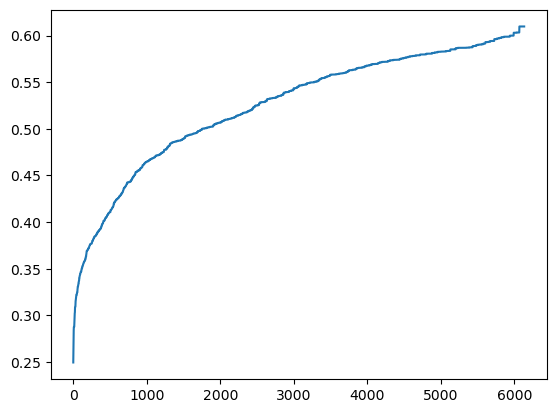

In [3]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_degrees)


seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### LOF Algorithm
TBD: choose if we want to use LOF or Isolation Forest

In [4]:
from sklearn.neighbors import LocalOutlierFactor

k = 25

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(data_only_dataset)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists.loc[:, "lof_degree"] = outlier_degrees

<Axes: >

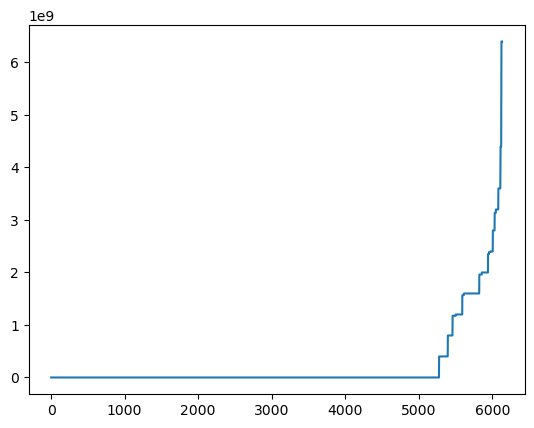

In [5]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

# to achieve comparable degrees among different algorithms,
# we normalize distance-based scores by the maximum possible distance
# distances = squareform(pdist(data_only_dataset.values))
# maximum_possible_radius = distances.max()
# normalization_factor = maximum_possible_radius / k
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "lof_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### One-class SVM

In [6]:
from sklearn.svm import OneClassSVM


kernel = "rbf"
# kernel = "linear"
# kernel = "poly"
algorithm = OneClassSVM(kernel=kernel)
algorithm.fit(data_only_dataset)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(data_only_dataset)
outlier_distance_scores = algorithm.score_samples(data_only_dataset)

cyclists.loc[:, "oneclass_svm_degree"] = outlier_distance_scores
cyclists.loc[:, "oneclass_svm_degree_binary"] = (outlier_classification_scores  + 1) % 2  # map to {0, 1}

if kernel == "linear":
    support_vectors = data_only_dataset.iloc[algorithm.support_]
    
else:
    support_vectors = None

<Axes: >

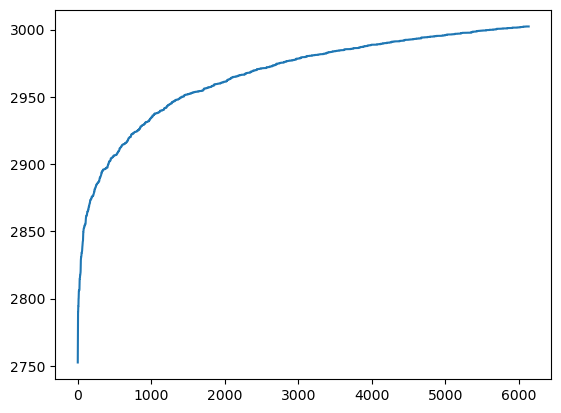

In [7]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_distance_scores)

# to achieve comparable degrees among different algorithms, we normalize distance-based scores by the maximum possible distance
# normalization_factor = sorted_outlier_degrees[-1]
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "oneclass_svm_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### Gaussian Mixture algorithm

In [8]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn


k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

cyclists.loc[:, "density_degree"] = outlier_degrees

<Axes: >

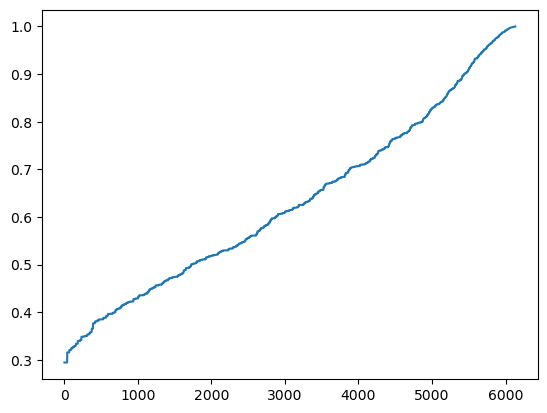

In [9]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### COPOD algorithm

<Axes: >

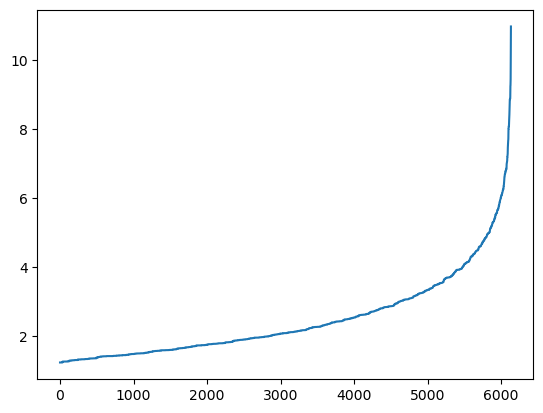

In [12]:
from pyod.models.copod import COPOD  # manifold-based

algorithm = COPOD()
algorithm.fit(data_only_dataset)
outlier_scores = algorithm.decision_function(data_only_dataset)
outlier_labels = algorithm.predict(data_only_dataset)
sorted_outlier_scores = sorted(outlier_scores)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_scores)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_scores
)